# Car reservation prediction
Our goal is to predict the number of reservations of vehicles.

# Data 
Due to confidentiality of the data, let's import, clean and PCA transform the feature space. 

In [3]:
import pandas as pd
df_vehicles = pd.read_csv('./vehicles.csv')
df_reservations = pd.read_csv('./reservations.csv')

In [189]:
#print('VEHICLES\n =============================================== \n',df_vehicles.head(4))
#print('\nRESERVATIONS\n ========================================== \n',df_reservations.head(4))

In [39]:
df = pd.merge(df_reservations,df_vehicles, how='inner', on='vehicle_id') # join on intersection on vehicle_id

In [194]:
print(df.iloc[0:5,2:])

   reservation_type  is_delivery  actual_price  recommended_price  num_images  \
0               2.0            0           121                 48           9   
1               2.0            0           121                 48           9   
2               2.0            1            61                 66          12   
3               2.0            1            61                 66          12   
4               1.0            1            61                 66          12   

   description_length  is_recent_model  
0                   0                0  
1                   0                0  
2                   0                0  
3                   0                0  
4                   0                0  


In [57]:
print('(samples, features) = %s'%str(df.shape))
print('max description length = %s'%str(df.description_length.max()))

(samples, features) = (195243, 9)
max description length = 7780


Let's do some EDA to get the feature space characteristics! We removed the "is_delivery" feature, since that's what we want to predict. Instead of using all 6 dim, which is hard to visualize, and also hard to select the right features to plot. Let's reduce the feature dimension by PCA to find how the samples projects onto the top 3 modes:

In [166]:
from sklearn.decomposition import PCA
nrows = df.shape[0]
df = df.dropna(axis=0) # drop NaNs
x = df.iloc[0:nrows, [2,*range(4,9)]].values # skip is_delivery since it's the tag
y = df.iloc[0:nrows,3].values # is_delivery is the tag to color mark on projected features
pca = PCA(n_components=x.shape[1]) # use all 

(193888, 6) (193888,)


In [167]:
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [168]:
s = pca.singular_values_
print(s)  # just the eigenvalues of the PC direction vectors, also the stdev of the PCs

[2.35818460e+05 3.15943855e+04 7.78928641e+03 2.22170080e+03
 2.13971098e+02 2.02733204e+02]


In [169]:
print(pca.explained_variance_ratio_) # ([i/sum(pca.singular_values_**2) for i in pca.singular_values_**2])

[9.81227787e-01 1.76130297e-02 1.07055649e-03 8.70934277e-05
 8.07838364e-07 7.25210377e-07]


The sigular values are just the PC stdev of the PC axes, and the explained variance are just the component variances (i.e., squared stdev) divide by the total variance. 

In [170]:
P = pca.transform(x) # the projection of all samples on all PC axes, 
PC_normal = numpy.asarray([P[:,i]/s[i] for i in range(len(s))]).T # normalized PC: PC divided by sigular values
# we can use P = PCA(n_components=2).transform(x)  if we just want the projections on the first 2 components, 
# this gives the same values as the full transformation, but just trancated 

Let's see how the projection behaves on the leading two modes in a plot:

Samples: Class 0 (red) = 51295, Class 1 (blue) = 142593


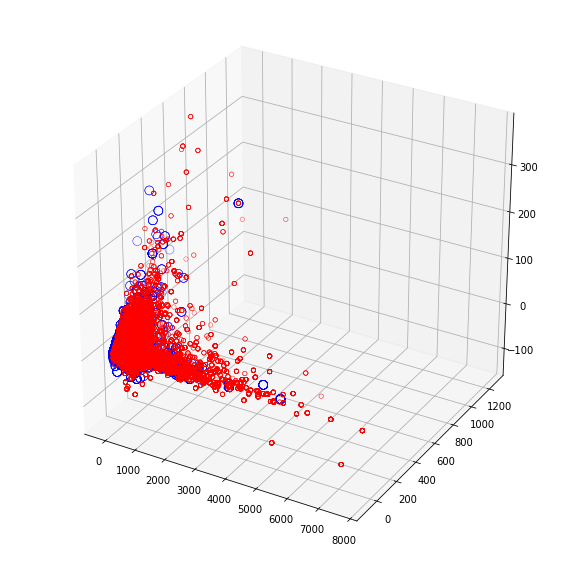

In [172]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
print("Samples: Class 0 (red) = %s, Class 1 (blue) = %s"%(sum(y==0),sum(y==1)))
ax.scatter(P[y==0,0], P[y==0,1], P[y==0,2], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax.scatter(P[y==1,0], P[y==1,1], P[y==1,2], edgecolors='r', s=20, facecolors='none', linewidths=0.5, label='Class 1')
plt.show()

Seems like the two classes are separated (except some outliers) in the PCA feature space with Class 0 (blue) more clustered and Class 1 (red) more scattered. This seems like we can do a "kernel trick" by transforming the data by the "closeness/L2 distance" to the cluster centroid. This is more of a geometric thinking from the plot.

Since rescaling is recommended for reasons such as making feature space more "spherical" instead of "elliptical" to speed up the stochastic gradient descent. Therefore we will just work on the normalized PC to avoid using `sklearn.preprocessing` to rescale the data.

We are going to look at logistic regression, SVM, random forest, XGBoost and move forward to DNN later.


Let's split the data into 80% training, 10% validation and 10% testing:

In [177]:
ntotal = PC_normal.shape[0]
ntrain = round(0.8*ntotal)
nvalid = round(0.9*ntotal)
x_train,x_valid,x_test = PC_normal[:ntrain,:], PC_normal[ntrain:nvalid,:], PC_normal[nvalid:,:]
y_train,y_valid,y_test = y[:ntrain], y[ntrain:nvalid], y[nvalid:]

In [178]:
print(ntotal,train.shape,valid.shape,test.shape)

193888 (155110, 6) (19389, 6) (19389, 6)


In [188]:
from sklearn.linear_model import LogisticRegression # logistic regression function p(x) = 1/(1+e^{b^T*x}), logit(p) = b^T*x
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial').fit(x_train,y_train) # multinomial uses cross entropy 
y_pred = logreg.predict(x_test)
report = classification_report(y_test,y_pred,target_names=['class 0','class 1'])
# X = [n_samples, n_features], y = [n_samples]
# C = Inverse of regularization strength; must be a positive float. 
#     Like in support vector machines, smaller values specify stronger regularization.
# solver = 'sag': stochastic average gradient descent
#        = 'lbfgs': some Newton method
print('first five actual classes = %s'%str(y_test[:2]))
print('first five predicted classes = %s'%str(logreg.predict(x_test[:2,:]))) # predict class vs real class
print('first five predicted probalities [0 vs 1] = %s'%str(logreg.predict_proba(x_test[:2,:]))) # predict
# print('score = %s'%str(logreg.score(x_test,y_test))) # Score is the ratio of correctly predicted (TP+TN) samples.
print(report) # support is just the # of samples detected or used

first five actual classes = [1 1]
first five predicted classes = [1 1]
first five predicted probalities [0 vs 1] = [[0.28882102 0.71117898]
 [0.28882102 0.71117898]]
              precision    recall  f1-score   support

     class 0       0.40      0.00      0.00      5150
     class 1       0.73      1.00      0.85     14239

   micro avg       0.73      0.73      0.73     19389
   macro avg       0.57      0.50      0.42     19389
weighted avg       0.65      0.73      0.62     19389

